# **DepthPro: Image Super Resolution (4x 256px)**

This work is a part of the [**DepthPro: Beyond Depth Estimation**](https://github.com/geetu040/depthpro-beyond-depth) repository, which further explores the model's capabilities in:

- **Image Segmentation**: Human Segmentation  
- **Image Super Resolution**:  
  - 384px to 1536px (4x Upscaling)  
  - 256px to 1024px (4x Upscaling)

---

## 🛠️ Training

- The model has been trained on **Nvidia A40 (48GB GDDR6 VRAM)**.  
- To train this model, ensure at least **48GB GPU memory** is available for **float16 training**.

---

## 🤗 Inference

- For Web UI Inference: [**spaces/geetu040/DepthPro_SR_4x_256p**](https://huggingface.co/spaces/geetu040/DepthPro_SR_4x_256p)
- For Code-Based Inference and model weights: [**geetu040/DepthPro_SR_4x_256p**](https://huggingface.co/geetu040/DepthPro_SR_4x_256p)

---

## 🌐 Learn More About DepthPro

Check out the following resources for more details:

- **Official Paper**: [Depth Pro: Sharp Monocular Metric Depth in Less Than a Second](https://arxiv.org/abs/2410.02073)  
- **GitHub Repository**: [apple/ml-depth-pro](https://github.com/apple/ml-depth-pro)  
- **Articles**:  
  - [Apple unveils Depth Pro, an AI app that can map the depth of a 2D image](https://techxplore.com/news/2024-10-apple-unveils-depth-pro-ai.html)  
  - [Apple releases Depth Pro, an AI model that rewrites the rules of 3D vision](https://venturebeat.com/ai/apple-releases-depth-pro-an-ai-model-that-rewrites-the-rules-of-3d-vision/)

---

## 📊 For a Better Notebook Experience

- Open the notebook on **Google Colab**:  
  [![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1J4UheUjCLS-oqOuay-JfPkIZZQXpnZGZ)
- Open the notebook on **Kaggle**:  
  [![Open in Kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://www.kaggle.com/code/sacrum/depthpro-superresolution-4x-256p/)

---

# Notebook Overview

This notebook modifies [Apple's DepthPro for Monocular Depth Estimation](https://arxiv.org/abs/2410.02073) model for `Image Super Resolution Task`.
1. The base model architechture is modified for the task of Image Super Resolution from 256px to 1024px (4x upsampling).
2. The model is trained on the [Div2K dataset](https://ieeexplore.ieee.org/document/8014884), tested on [Urban100 dataset](https://www.cv-foundation.org/openaccess/content_cvpr_2015/html/Huang_Single_Image_Super-Resolution_2015_CVPR_paper.html) and final results have been visualized at the end of the notebook.

# Imports and Initial Setup

<details>

<summary>Installing Packages</summary>

```py
!pip install -q numpy pandas matplotlib pillow kagglehub lightning torch torchmetrics torchvision
!pip install -q git+https://github.com/geetu040/transformers.git@depth-pro-projects#egg=transformers
```

</details>

In [1]:
import os
import random
import math
import time
import kagglehub
from tqdm import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image

import lightning as L
from lightning.pytorch.callbacks import ModelCheckpoint, EarlyStopping
from lightning.pytorch.loggers import CSVLogger, TensorBoardLogger

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from torchmetrics.audio import SignalNoiseRatio
from torchmetrics.image import PeakSignalNoiseRatio, StructuralSimilarityIndexMeasure

# custom installation from this PR: https://github.com/huggingface/transformers/pull/34583
# !pip install git+https://github.com/geetu040/transformers.git@depth-pro-projects#egg=transformers
from transformers import DepthProConfig, DepthProImageProcessorFast, DepthProForDepthEstimation

In [2]:
LR_SIZE = 256
SCALE_FACTOR = 4
HR_SIZE = LR_SIZE * SCALE_FACTOR

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 1  # each image can be of variable size

print("Low Resolution Size:", LR_SIZE)
print("High Resolution Size:", HR_SIZE)
print("Scale Factor:", SCALE_FACTOR)
print("Device:", DEVICE)
print("Batch Size:", BATCH_SIZE)

Low Resolution Size: 256
High Resolution Size: 1024
Scale Factor: 4
Device: cuda
Batch Size: 1


# Data Preparation

For `training` and `validation`, we use `Div2k` dataset, introduced in [NTIRE 2017 Challenge on Single Image Super-Resolution: Dataset and Study](https://ieeexplore.ieee.org/document/8014884)
- It contains high resolution images in 2k resolution, which have been downsampled to `LR_SIZE=256` and `HR_SIZE=1024` for training and validation.
- It contains
    - 800 training samples
    - 200 validation samples
- Dataset has been downloaded from kaggle: [soumikrakshit/div2k-high-resolution-images](https://www.kaggle.com/datasets/soumikrakshit/div2k-high-resolution-images)

For `testing`, we use `Urban100` dataset, introduced in [Single Image Super-Resolution From Transformed Self-Exemplars](https://www.cv-foundation.org/openaccess/content_cvpr_2015/html/Huang_Single_Image_Super-Resolution_2015_CVPR_paper.html)
- It contains images in 2 resolutions, 256 (low) and 1024 (high).
- It contains 100 samples.
- Dataset has been downloaded from kaggle: [harshraone/urban100](https://www.kaggle.com/datasets/harshraone/urban100)

create pytorch dataset class

In [3]:
class Div2kDataset(Dataset):
    """
    Pytorch Dataset for Div2K dataset.
    """
    kaggle_hub_path = "soumikrakshit/div2k-high-resolution-images"
    train_path = "DIV2K_train_HR/DIV2K_train_HR"
    validation_path = "DIV2K_valid_HR/DIV2K_valid_HR"
    orig_image_size = 2048 # images are in 2k resolution

    def __init__(
        self,
        split,
        lr_size=384,
        hr_size=1536,
        keep_aspect_ratio=False,
    ):
        self.split = split
        self.lr_size = lr_size
        self.hr_size = hr_size
        self.keep_aspect_ratio = keep_aspect_ratio
        self.images_paths = self.download(split)

    def download(self, split):
        """
        Download the dataset from Kaggle Hub and return the paths of the images.
        """
        path = kagglehub.dataset_download(self.kaggle_hub_path)

        if split == "train":
            path = os.path.join(path, self.train_path)
        elif split == "validation":
            path = os.path.join(path, self.validation_path)
        else:
            raise ValueError(f'Incorrect split={split}, select from ("train", "validation")')

        images_paths = [os.path.join(path, i) for i in os.listdir(path)]
        return images_paths

    def __len__(self):
        """
        Number of Images in a split ('train' or 'validation').
        """
        return len(self.images_paths)

    def _crop_image(self, image):
        """
        Crops the image from the center to make aspect ratio 1:1.
        """
        # crop images from center to make aspect ratio 1:1
        width, height = image.size
        min_dim = min(width, height)
        left = (width - min_dim) // 2
        top = (height - min_dim) // 2
        right = left + min_dim
        bottom = top + min_dim
        image = image.crop((left, top, right, bottom))
        return image

    def __getitem__(self, idx):
        """
        Load and return the Low Resolution (lr) and High Resolution (hr) image.
        """
        image_path = self.images_paths[idx]
        image = Image.open(image_path)
        image = image.convert("RGB")

        if self.keep_aspect_ratio:
            lr = image
            hr = image.copy()
            lr.thumbnail((self.lr_size, self.lr_size))
            hr.thumbnail((self.hr_size, self.hr_size))
        else:
            image = self._crop_image(image)
            lr = image.resize((self.lr_size, self.lr_size), Image.Resampling.BICUBIC)
            hr = image.resize((self.hr_size, self.hr_size), Image.Resampling.BICUBIC)

        return lr, hr

class Urban100Dataset(Dataset):
    """
    Pytorch Dataset for Urban100 dataset.
    """
    kaggle_hub_path = "harshraone/urban100"
    lr_path = 'Urban 100/X4 Urban100/X4/LOW x4 URban100'
    hr_path = 'Urban 100/X4 Urban100/X4/HIGH x4 URban100'

    def __init__(self):
        lr_images_path, hr_images_path = self.download()
        self.lr_images_path = lr_images_path
        self.hr_images_path = hr_images_path

    def download(self):
        """
        Download the dataset from Kaggle Hub and return the paths of the images.
        """
        path = kagglehub.dataset_download(self.kaggle_hub_path)
        lr_images_path = os.path.join(path, self.lr_path)
        hr_images_path = os.path.join(path, self.hr_path)
        lr_images_path = [os.path.join(lr_images_path, i) for i in os.listdir(lr_images_path)]
        hr_images_path = [os.path.join(hr_images_path, i) for i in os.listdir(hr_images_path)]
        return lr_images_path, hr_images_path

    def __len__(self):
        """
        Number of Images in the dataset.
        """
        return len(self.lr_images_path)

    def __getitem__(self, idx):
        """
        Load and return the Low Resolution (lr) and High Resolution (hr) image.
        """
        lr = Image.open(self.lr_images_path[idx]).convert("RGB")
        hr = Image.open(self.hr_images_path[idx]).convert("RGB")
        return lr, hr

initialize the dataset and dataloader objects

In [4]:
# create datasets

train_dataset = Div2kDataset(
    split="train",
    lr_size=LR_SIZE,
    hr_size=HR_SIZE,
    keep_aspect_ratio=True,
)
validation_dataset = Div2kDataset(
    split="validation",
    lr_size=LR_SIZE,
    hr_size=HR_SIZE,
    keep_aspect_ratio=True,
)
test_dataset = Urban100Dataset()

# create dataloaders

processor = DepthProImageProcessorFast(do_resize=False, do_rescale=True, do_normalize=True)
def collate_fn(samples):
    lrs = [i[0] for i in samples]
    hrs = [i[1] for i in samples]
    lrs = processor(lrs, return_tensors="pt")['pixel_values']
    hrs = processor(hrs, return_tensors="pt")['pixel_values']
    return lrs, hrs

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=4
)
val_loader = DataLoader(
    validation_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    collate_fn=collate_fn,
    num_workers=4
)
test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    collate_fn=collate_fn,
    num_workers=4
)

visualize a sample from the dataset

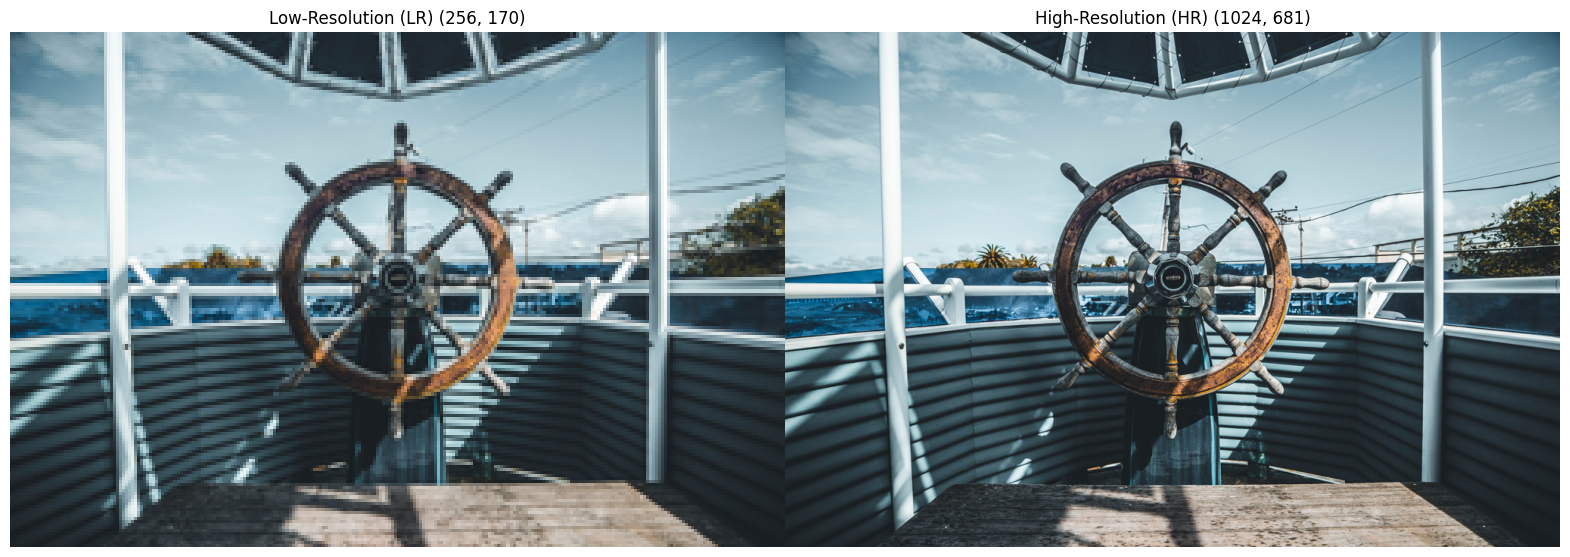

In [5]:
test_lr, test_hr = validation_dataset[23]

# visulaize a sample
fig, axes = plt.subplots(1, 2, figsize=(20, 20))
axes[0].imshow(test_lr)
axes[0].set_title(f'Low-Resolution (LR) {test_lr.size}')
axes[0].axis('off')
axes[1].imshow(test_hr)
axes[1].set_title(f'High-Resolution (HR) {test_hr.size}')
axes[1].axis('off')
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

# Model Architecture

Update the default model architechture for Super Resolution task

In [6]:
patch_size = 32
patch_embeddings_size = 4
num_hidden_layers = 12
intermediate_hook_ids=[11, 8, 7, 5]
intermediate_feature_dims=[256] * len(intermediate_hook_ids)
scaled_images_ratios=[0.5, 1.0]
scaled_images_overlap_ratios=[0.5, 0.25]
scaled_images_feature_dims=[1024, 512]

base_size = patch_size // patch_embeddings_size
n_upsample_layers = len(intermediate_hook_ids) + len(scaled_images_ratios) + 1
sr_size = 2 ** n_upsample_layers * patch_size // patch_embeddings_size

print("Base Size:", base_size)
print("No of Upsample Layers:", n_upsample_layers)
print("LR Size:", LR_SIZE)
print("SR Size:", sr_size)
print("HR Size:", HR_SIZE)

Base Size: 8
No of Upsample Layers: 7
LR Size: 256
SR Size: 1024
HR Size: 1024


load the pretrained model from huggingface hub

In [7]:
config = DepthProConfig(
    patch_size=patch_size,
    patch_embeddings_size=patch_embeddings_size,
    num_hidden_layers=num_hidden_layers,
    intermediate_hook_ids=intermediate_hook_ids,
    intermediate_feature_dims=intermediate_feature_dims,
    scaled_images_ratios=scaled_images_ratios,
    scaled_images_overlap_ratios=scaled_images_overlap_ratios,
    scaled_images_feature_dims=scaled_images_feature_dims,
    use_fov_model=False,
)

depthpro_for_depth_estimation, info = DepthProForDepthEstimation.from_pretrained(
	"geetu040/DepthPro",
    revision="project",
    config=config,
    ignore_mismatched_sizes=True,
    output_loading_info=True,
)

for k, v in info.items():
    print(k, len(v))

Some weights of DepthProForDepthEstimation were not initialized from the model checkpoint at geetu040/DepthPro and are newly initialized: ['depth_pro.encoder.feature_projection.projections.4.weight', 'depth_pro.encoder.feature_upsample.upsample_blocks.3.2.weight', 'depth_pro.encoder.feature_upsample.upsample_blocks.4.3.weight', 'depth_pro.encoder.feature_upsample.upsample_blocks.5.4.weight', 'depth_pro.encoder.feature_upsample.upsample_blocks.6.0.weight', 'depth_pro.encoder.feature_upsample.upsample_blocks.6.1.weight', 'depth_pro.encoder.feature_upsample.upsample_blocks.6.2.weight', 'depth_pro.encoder.feature_upsample.upsample_blocks.6.3.weight', 'depth_pro.encoder.feature_upsample.upsample_blocks.6.4.weight', 'depth_pro.encoder.feature_upsample.upsample_blocks.6.5.weight', 'fusion_stage.layers.4.deconv.weight', 'fusion_stage.layers.5.projection.bias', 'fusion_stage.layers.5.projection.weight', 'fusion_stage.layers.5.residual_layer1.convolution1.bias', 'fusion_stage.layers.5.residual_l

missing_keys 21
unexpected_keys 880
mismatched_keys 10
error_msgs 0


create custom pytorch model for super resolution task on top of depth estimation model loaded above

In [8]:
class DepthProForSuperResolution(nn.Module):
    def __init__(self, depthpro_for_depth_estimation):
        super(DepthProForSuperResolution, self).__init__()

        self.depthpro_for_depth_estimation = depthpro_for_depth_estimation
        hidden_size = self.depthpro_for_depth_estimation.config.fusion_hidden_size

        self.image_head = torch.nn.Sequential(
            torch.nn.ConvTranspose2d(
                in_channels=config.num_channels,
                out_channels=hidden_size,
                kernel_size=4, stride=2, padding=1
            ),
            torch.nn.ReLU(),
        )

        self.head = torch.nn.Sequential(
            torch.nn.Conv2d(
                in_channels=hidden_size,
                out_channels=hidden_size,
                kernel_size=3, stride=1, padding=1
            ),
            torch.nn.ReLU(),
            torch.nn.ConvTranspose2d(
                in_channels=hidden_size,
                out_channels=hidden_size,
                kernel_size=4, stride=2, padding=1
            ),
            torch.nn.ReLU(),
            torch.nn.Conv2d(
                in_channels=hidden_size,
                out_channels=self.depthpro_for_depth_estimation.config.num_channels,
                kernel_size=3, stride=1, padding=1
            ),
        )

    def forward(self, x):
        # x is the low resolution image
        encoder_features = self.depthpro_for_depth_estimation.depth_pro(x).features
        fused_hidden_state = self.depthpro_for_depth_estimation.fusion_stage(encoder_features)[-1]
        x = self.image_head(x)
        x = torch.nn.functional.interpolate(x, size=fused_hidden_state.shape[2:])
        x = x + fused_hidden_state
        x = self.head(x)
        return x

# Training

create pytorch lightning module for training the model

In [9]:
class LightningModel(L.LightningModule):
    def __init__(self, depthpro_for_depth_estimation):
        super().__init__()
        self.model = DepthProForSuperResolution(depthpro_for_depth_estimation)
        self.snr = SignalNoiseRatio()
        self.psnr = PeakSignalNoiseRatio()
        self.ssim = StructuralSimilarityIndexMeasure()
        self.mse = nn.MSELoss()

    def training_step(self, batch, batch_idx):
        lr, hr = batch
        sr = self.model(lr)
        sr = F.interpolate(sr, size=hr.shape[2:])

        loss = self.mse(sr, hr)

        self.log("train_mse_loss", loss, prog_bar=True)
        self.log("train_mean_grad_norm", self.log_gradient_norms(), prog_bar=True)
        self.log("train_lr", self.optimizers().param_groups[0]['lr'], prog_bar=True)

        return loss

    def validation_step(self, batch, batch_idx):
        lr, hr = batch
        sr = self.model(lr)
        sr = F.interpolate(sr, size=hr.shape[2:])

        mse_loss = self.mse(sr, hr)
        psnr_value = self.psnr(sr, hr)
        ssim_value = self.ssim(sr, hr)
        snr_value = self.snr(sr, hr)

        self.log("val_mse_loss", mse_loss, prog_bar=True)
        self.log("val_psnr", psnr_value, prog_bar=True)
        self.log("val_ssim", ssim_value, prog_bar=True)
        self.log("val_snr", snr_value, prog_bar=True)

        # also log the first image in validation set
        if batch_idx == 0:
            # fix output shape
            sr_image = torch.permute(sr[0].detach().cpu(), (1, 2, 0)).float().numpy()
            # fix normalization
            sr_image = sr_image * 0.5 + 0.5
            # fix out of range
            sr_image = sr_image.clip(0.0, 1.0)
            # save the image
            # fix sr_image_save_path for me as well as make sure this directory is created if there is not one
            save_dir = os.path.join(self.logger.save_dir, self.logger.name, f"version_{self.logger.version}", "sr_images")
            os.makedirs(save_dir, exist_ok=True)
            sr_image_save_path = os.path.join(save_dir, f"{self.global_step}.png")
            plt.matshow(sr_image)
            plt.axis('off')
            plt.savefig(sr_image_save_path)
            plt.close()
            # self.logger.experiment.add_image("SR Image", sr_image, self.global_step)

        return mse_loss

    def test_step(self, batch, batch_index):
        lr, hr = batch
        sr = self.model(lr)
        sr = F.interpolate(sr, size=hr.shape[2:])

        mse_loss = self.mse(sr, hr)
        psnr_value = self.psnr(sr, hr)
        ssim_value = self.ssim(sr, hr)
        snr_value = self.snr(sr, hr)

        self.log("test_mse_loss", mse_loss)
        self.log("test_psnr", psnr_value)
        self.log("test_ssim", ssim_value)
        self.log("test_snr", snr_value)

        return mse_loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-4)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.7)
        # lr = lr * gamma ** step_size; where step_size = epoch
        return [optimizer], [scheduler]

    def log_gradient_norms(self):
        total_grad_norm = 0.0
        num_params = 0
        for param in self.parameters():
            if param.grad is not None:
                total_grad_norm += param.grad.norm(2).item()
                num_params += 1
        if num_params == 0:
            return 0
        return total_grad_norm / num_params

initialize and run the trainer

In [10]:
# Save the top 3 models based on PSNR score
checkpoint_callback = ModelCheckpoint(
    monitor='val_psnr',
    mode='max',
    save_top_k=3,
    filename='model-{epoch:02d}-{val_psnr:.2f}',
    save_weights_only=True,
)

# Stop training if PSNR does not improve for 3 epochs
early_stopping_callback = EarlyStopping(
    monitor='val_psnr',
    mode='max',
    patience=3,
    verbose=True,
    min_delta=0.1,
)

# Create Lightening Trainer
trainer = L.Trainer(
    accelerator="gpu",
    devices=[0],
    max_epochs=10,
    precision=16, # 16, 32 (original)
    # logger=TensorBoardLogger("logs", name="SuperResolution_4x_256p"),
    logger=CSVLogger("logs", name="SuperResolution_4x_256p"),
    log_every_n_steps=50,
    callbacks=[checkpoint_callback, early_stopping_callback],
    gradient_clip_val=1.0,
    gradient_clip_algorithm="norm", # norm, value
)

# Initialize the model
model = LightningModel(depthpro_for_depth_estimation)

# Training the model
trainer.fit(model=model, train_dataloaders=train_loader, val_dataloaders=val_loader)

/usr/local/lib/python3.10/dist-packages/lightning/fabric/connector.py:572: `precision=16` is supported for historical reasons but its usage is discouraged. Please set your precision to 16-mixed instead!
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A40') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type                             | Params | Mode 
-------------------------------------------------------------------
0 | model | DepthProForSuperResolution       | 343 M  | train
1 | snr   | SignalNoiseRatio                 | 0   

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_psnr improved. New best score: 22.406


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_psnr improved by 0.785 >= min_delta = 0.1. New best score: 23.191


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_psnr improved by 1.229 >= min_delta = 0.1. New best score: 24.419


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_psnr improved by 0.146 >= min_delta = 0.1. New best score: 24.565


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_psnr improved by 0.145 >= min_delta = 0.1. New best score: 24.710


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Monitored metric val_psnr did not improve in the last 3 records. Best score: 24.710. Signaling Trainer to stop.


visualize the training logs

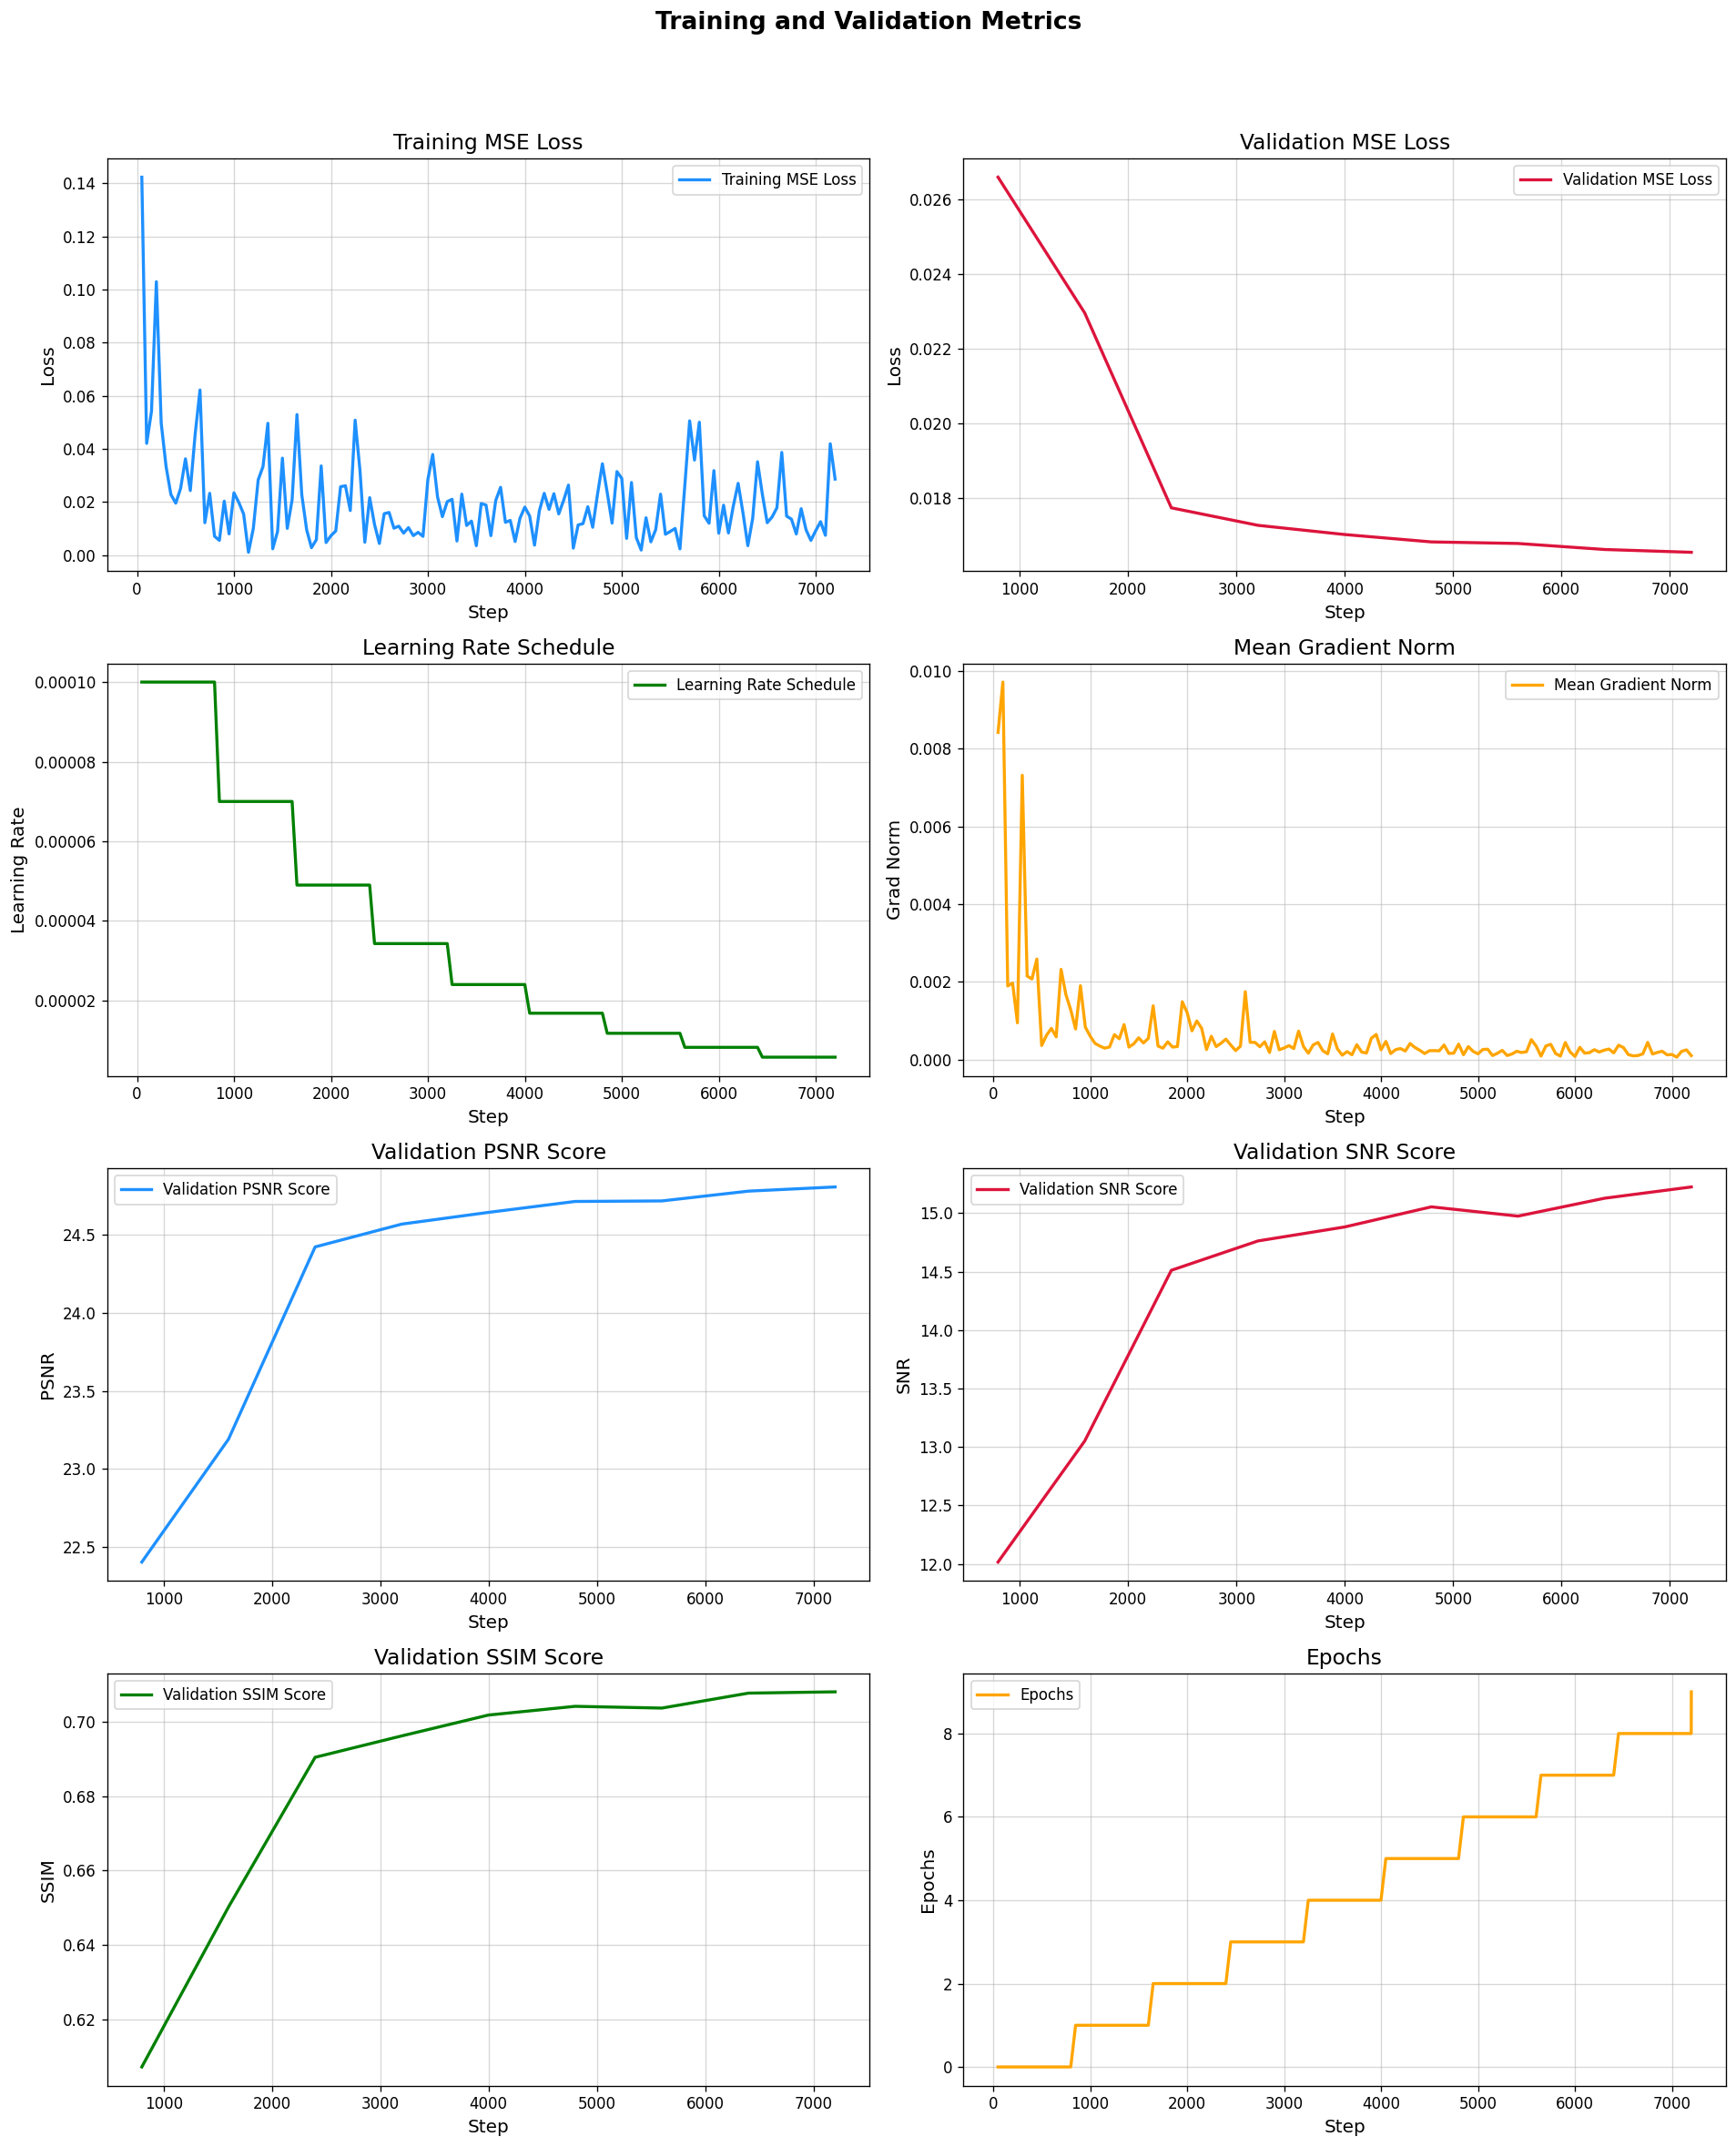

In [12]:
logs_path = f"{trainer.logger.save_dir}/{trainer.logger.name}/version_{trainer.logger.version}/metrics.csv"
df = pd.read_csv(logs_path)

# Define the metrics to plot and their properties
metrics = [
    {"column": "train_mse_loss", "title": "Training MSE Loss", "ylabel": "Loss", "color": "dodgerblue"},
    {"column": "val_mse_loss", "title": "Validation MSE Loss", "ylabel": "Loss", "color": "crimson"},
    {"column": "train_lr", "title": "Learning Rate Schedule", "ylabel": "Learning Rate", "color": "green"},
    {"column": "train_mean_grad_norm", "title": "Mean Gradient Norm", "ylabel": "Grad Norm", "color": "orange"},
    {"column": "val_psnr", "title": "Validation PSNR Score", "ylabel": "PSNR", "color": "dodgerblue"},
    {"column": "val_snr", "title": "Validation SNR Score", "ylabel": "SNR", "color": "crimson"},
    {"column": "val_ssim", "title": "Validation SSIM Score", "ylabel": "SSIM", "color": "green"},
    {"column": "epoch", "title": "Epochs", "ylabel": "Epochs", "color": "orange"},
]

# Determine grid size based on the number of metrics
n_metrics = len(metrics)
n_cols = 2  # Number of columns in the plot grid
n_rows = (n_metrics + n_cols - 1) // n_cols  # Calculate rows needed

# Create a figure and axes
fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 5 * n_rows), dpi=120)
fig.suptitle("Training and Validation Metrics", fontsize=16, weight='bold')

# Flatten axes array for easy iteration
axes = axes.flatten()

# Plot each metric
for i, metric in enumerate(metrics):
    column = metric["column"]
    title = metric["title"]
    ylabel = metric["ylabel"]
    color = metric["color"]

    valid_values = ~ df[column].isna()
    axes[i].plot(df['step'][valid_values], df[column][valid_values], label=title, color=color, lw=2)
    axes[i].set_title(title, fontsize=14)
    axes[i].set_xlabel("Step", fontsize=12)
    axes[i].set_ylabel(ylabel, fontsize=12)
    axes[i].grid(alpha=0.5)
    axes[i].legend()

# Hide unused subplots if the number of metrics is less than the grid size
for j in range(len(metrics), len(axes)):
    fig.delaxes(axes[j])

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.95])

# Show the plots
plt.show()


test the model on test data

In [ ]:
# Test the model
trainer.test(dataloaders=test_loader)

# captured from the output
"""
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_mse_loss         0.03634364902973175
        test_psnr           21.361988067626953
        test_snr            11.224209785461426
        test_ssim           0.6180700659751892
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
"""

/usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:145: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
Restoring states from the checkpoint path at logs/SuperResolution_4x_256p/version_3/checkpoints/model-epoch=08-val_psnr=24.80.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at logs/SuperResolution_4x_256p/version_3/checkpoints/model-epoch=08-val_psnr=24.80.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_mse_loss         0.03634364902973175
        test_psnr           21.361988067626953
        test_snr            11.224209785461426
        test_ssim           0.6180700659751892
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


'\n────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────\n       Test metric             DataLoader 0\n────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────\n      test_mse_loss         0.04015875235199928\n        test_psnr           20.801523208618164\n        test_snr             10.37308120727539\n        test_ssim           0.5984361171722412\n────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────\n'

# Validation and Inference

Model has achieve best `PSRN score of 24.80` and `SSIM score of 0.74` on validation set, we are going to use this checkpoint for inference

In [14]:
model_name = 'model-epoch=08-val_psnr=24.80.ckpt'

checkpoint_path = f"logs/SuperResolution_4x_256p/version_3/checkpoints/{model_name}"
pl_model = LightningModel.load_from_checkpoint(
    checkpoint_path,
    depthpro_for_depth_estimation=depthpro_for_depth_estimation,
    map_location=torch.device('cpu')
)
model = pl_model.model
model = model.to(DEVICE)

In [17]:
num_samples = 9

dataset = validation_dataset
# dataset = test_dataset

indexes = random.sample(range(0, len(dataset)), num_samples)

lrs, hrs, srs = [], [], []
for index in tqdm(indexes):
    lr, hr = dataset[index]

    input = processor(lr, return_tensors="pt") # creates python dictionary
    input = input['pixel_values']              # extracts tensors
    input = input.to(DEVICE)                   # load to cuda
    with torch.no_grad():
        output = model(input)                  # inference
    output = output.cpu()                      # unload from cuda
    # interpolate slight offset in output from hr
    output = F.interpolate(output, size=(hr.height, hr.width))
    output = output[0]                         # extract the first and only batch
    output = torch.permute(output, (1, 2, 0))  # (C, H, W) -> (H, W, C)
    output = output * 0.5 + 0.5                # undo normalization
    output = output * 255.                     # undo scaling
    output = output.clip(0, 255.)              # fix out of range
    output = output.numpy()                    # convert to numpy
    output = output.astype('uint8')            # convert to PIL.Image compatible format

    sr = Image.fromarray(output)              # create PIL.Image object

    lrs.append(lr)
    hrs.append(hr)
    srs.append(sr)

100%|██████████| 9/9 [00:04<00:00,  2.02it/s]


In [ ]:
def random_crop(image, left, top, crop_width, crop_height):
    # Crop the image using the predefined coordinates
    right = left + crop_width
    bottom = top + crop_height
    cropped_image = image.crop((left, top, right, bottom))
    return cropped_image

n_rows = len(lrs)
fig, axes = plt.subplots(n_rows*2, 3, figsize=(21, 15*3*2))

for i, (lr, sr, hr) in enumerate(zip(lrs, srs, hrs)):
    # Random scale factor (less than 1.0)
    crop_scale = random.uniform(0.3, 0.5)

    # Get the size of the low-resolution image (assuming all images are at least the same size or larger)
    original_width, original_height = lr.size

    # Crop dimensions based on the LR image size
    crop_width = int(original_width * crop_scale)
    crop_height = int(original_height * crop_scale)

    # Randomly select the top-left corner of the crop
    left = random.randint(0, original_width - crop_width)
    top = random.randint(0, original_height - crop_height)

    # Apply the same crop window for all images (lr, sr, hr)
    lr_cropped = random_crop(lr, left, top, crop_width, crop_height)
    sr_cropped = random_crop(sr, left*SCALE_FACTOR, top*SCALE_FACTOR, crop_width*SCALE_FACTOR, crop_height*SCALE_FACTOR)
    hr_cropped = random_crop(hr, left*SCALE_FACTOR, top*SCALE_FACTOR, crop_width*SCALE_FACTOR, crop_height*SCALE_FACTOR)

    # Plotting the images
    axes[i*2, 0].imshow(lr)
    axes[i*2, 0].axis('off')
    axes[i*2, 1].imshow(sr)
    axes[i*2, 1].axis('off')
    axes[i*2, 2].imshow(hr)
    axes[i*2, 2].axis('off')

    # Plotting the cropped images
    axes[i*2+1, 0].imshow(lr_cropped)
    axes[i*2+1, 0].axis('off')
    axes[i*2+1, 1].imshow(sr_cropped)
    axes[i*2+1, 1].axis('off')
    axes[i*2+1, 2].imshow(hr_cropped)
    axes[i*2+1, 2].axis('off')
    
    if i == 0:
        axes[i, 0].set_title(f'Low-Resolution (LR) {lr_cropped.size}')
        axes[i, 1].set_title(f'Super-Resolution (SR) {sr_cropped.size}')
        axes[i, 2].set_title(f'High-Resolution (HR) {hr_cropped.size}')

plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

<a href="assets/validation_outputs/SuperResolution_4x_256p.png">
    <img src="assets/validation_outputs/SuperResolution_4x_256p.png" alt="validation_outputs/SuperResolution_4x_256p" width="100%">
</a>